# Worksheet 17

Name: Victor Verma
UID: U86967149

### Topics

- Recommender Systems

### Recommender Systems

In the example in class of recommending movies to users we used the movie rating as a measure of similarity between users and movies and thus the predicted rating for a user is a proxy for how highly a movie should be recommended. So the higher the predicted rating for a user, the higher a recommendation it would be.

a) Consider a streaming platform that only has "like" or "dislike" (no 1-5 rating). Describe how you would build a recommender system in this case.

First, I would make the user-rating matrix M, where the rows are the users and the columns are the movies. In some spot M[i][j], I would put a 1 if user i liked movie j, otherwise 0. In this case, because it seems like we have information both about the user and the movies, I would take a neighborhood-based approach. In this case, I think it makes the most sense to use a combination of a user, user similarity measure, because we have each user's ratings, but also an item, item similarity measure because we also have the movie information as the streaming service. I would personally value these equally, but the weightage of each could vary. Based on the combination of both of these similarity scores, I would get an overall predicted similarity score for any given unseen movie. Using the predicted rating as a proxy for recommendation, I would recommend the movie with the highest predicted rating.

b) Describe 3 challenges of building a recommender system

- The first challenge can be the scale of the data. There could be millions of users and ratings, and so it may be too computationally intensive to use everything. How do you choose an accurate sample of the data that can still be generalized to everyone?
- The user base and the thing being rating could constantly be changing. New users might join the platform, and new things might get added. To accomodate this, the system would need to be constantly updating (at some interval of time).
- It might be hard to actually get data. To recommend things, users would need to rate them, and naturally most users do not rate things. This could also lead to the voluntary response bias, which is when only the most extreme opinions are present because people in the middle could not be bothered to give a rating.

c) Why is SVD not an option for collaborative filtering?

The main problem with using SVD in this case is that the user-item matrix is sparse, and so this will lead to less accurate recommendations. 

d) Use the code below to train a recommender system on a dataset of amazon movies

In [4]:
%pip install findspark
%pip install pyspark


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488497 sha256=b773cca65fcd9ea2cba24bbb2cbdf30440e1a9bc2e15aba1b0e1570c90b90575
  Stored in directory: /Users/victor/Library/Caches/pip/wheels/95/13/41/f7f135ee114175605fb4f0a89e7389f3742aa6c1e1a5bcb657
Successfully built pyspark

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


24/04/05 18:08:57 WARN TaskSetManager: Stage 5122 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 18:08:57 WARN TaskSetManager: Stage 5123 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 18:08:58 WARN TaskSetManager: Stage 5126 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 18:08:58 WARN TaskSetManager: Stage 5129 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 18:09:03 WARN TaskSetManager: Stage 5209 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 18:09:04 WARN TaskSetManager: Stage 5235 contains a task of very large size (1008 KiB). The maximum recommended task size is 1000 KiB.
24/04/05 18:09:06 WARN TaskSetManager: Stage 5291 contains a task of very large size (1008 KiB). The maximum recommended task size is 10

Kaggle RMSE =  2.9578677263671036
Kaggle RMSE (Rounded Predictions) =  3.306055050963308


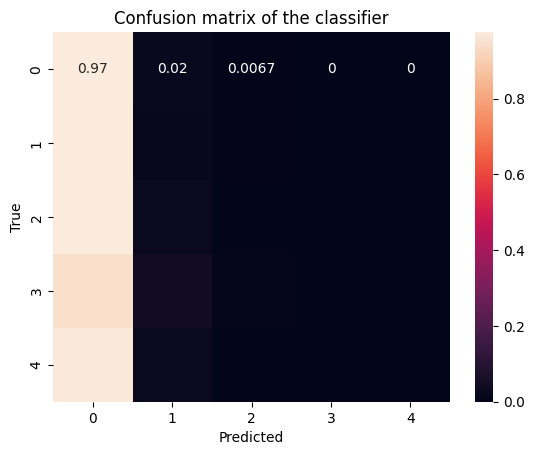

In [31]:
# Note: requires py3.10
import findspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

findspark.init()
conf = SparkConf()
conf.set("spark.executor.memory","28g")
conf.set("spark.driver.memory", "28g")
conf.set("spark.driver.cores", "8")
sc = SparkContext.getOrCreate(conf)
spark = SparkSession.builder.getOrCreate()

init_df = pd.read_csv("./train.csv").dropna()
init_df['UserId_fact'] = init_df['UserId'].astype('category').cat.codes
init_df['ProductId_fact'] = init_df['ProductId'].astype('category').cat.codes
init_df["Helpfulness"] = init_df["HelpfulnessNumerator"] / init_df["HelpfulnessDenominator"]

# Split training set into training and testing set
X_train_processed, X_test_processed, Y_train, Y_test = train_test_split(
        init_df.drop(['Score'], axis=1),
        init_df['Score'],
        test_size=1/4.0,
        random_state=0
    )
X_train_processed['Score'] = Y_train
df = spark.createDataFrame(X_train_processed[['UserId_fact', 'ProductId_fact', "HelpfulnessNumerator", "HelpfulnessDenominator", "Helpfulness", "Summary", "Text", "Time", 'Score']])
als = ALS(
    userCol="UserId_fact",
    itemCol="ProductId_fact",
    ratingCol="Score",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=100
)
param_grid = ParamGridBuilder().addGrid(
        als.rank, [10, 50]).addGrid(
        als.regParam, [.1]).addGrid(
        als.maxIter, [10]).build()
evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="Score", 
        predictionCol="prediction")
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3, parallelism = 6)
cv_fit = cv.fit(df)
rec_sys = cv_fit.bestModel

# rec_sys = als.fit(df)
# rec_sys.save('rec_sys.obj') # so we don't have to re-train it
rec = rec_sys.transform(spark.createDataFrame(X_test_processed[['UserId_fact', 'ProductId_fact', "HelpfulnessNumerator", "HelpfulnessDenominator", "Helpfulness", "Summary", "Text", "Time"]])).toPandas()
merged = X_test_processed[["UserId_fact", "ProductId_fact"]].join(
    rec.set_index(["UserId_fact", "ProductId_fact"]),
    on=["UserId_fact", "ProductId_fact"],
    how="left"
)

# Fill in the missing values with a default value (e.g., 0)
merged["Score"] = merged["prediction"].fillna(merged["prediction"].mean())
print("Kaggle RMSE = ", mean_squared_error(merged["Score"], Y_test, squared=False))

merged["Score"] = merged["Score"].apply(lambda x: max(1, min(5, round(x))))
print("Kaggle RMSE (Rounded Predictions) = ", mean_squared_error(merged["Score"], Y_test, squared=False))

cm = confusion_matrix(Y_test, merged['Score'], normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()